<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/GRU_LSTM/GRU_LSTM_Google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 4.29 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Mon Jul 19 19:35:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Google'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'GRU_LSTM'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 8.2 MB/s 
     |████████████████████████████████| 170 kB 59.5 MB/s 
     |████████████████████████████████| 97 kB 8.9 MB/s 
     |████████████████████████████████| 133 kB 70.2 MB/s 
     |████████████████████████████████| 138 kB 75.2 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 62 kB 883 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(GRU(units=64, activation=config.activation, return_sequences=True, input_shape=(window_len, 1)))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(LSTM(units=64, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 3
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: bqv8am73
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_GRU_LSTM/sweeps/bqv8am73


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: bt1kpyul with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
16/16 [==============================] - 23s 77ms/step - loss: 0.0609 - mean_squared_error: 0.0609 - mean_absolute_error: 0.1651 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1031
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0472 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0987
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0407 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0984
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0438 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0948
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_er

epoch,99
loss,0.00101
mean_squared_error,0.00101
mean_absolute_error,0.02344
val_loss,0.00498
val_mean_squared_error,0.00498
val_mean_absolute_error,0.05599
_runtime,46
_timestamp,1626723435
_step,99
best_val_loss,0.00498


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▆▄▅▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▃▁▃▁▁
val_mean_squared_error,█▇▆▆▅▆▄▅▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▃▁▃▁▁
val_mean_absolute_error,█▇▆▆▅▆▅▅▄▄▄▄▄▃▃▃▃▃▄▃▃▂▂▃▂▂▂▂▂▂▂▂▃▁▂▃▁▃▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 87nbapmm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 4s 66ms/step - loss: 0.1038 - mean_squared_error: 0.1038 - mean_absolute_error: 0.2309 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1056
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0713 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0969
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0430 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0868
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0325 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0860
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0021 - mean_squared_er

epoch,99
loss,0.00089
mean_squared_error,0.00089
mean_absolute_error,0.02173
val_loss,0.00554
val_mean_squared_error,0.00554
val_mean_absolute_error,0.05825
_runtime,27
_timestamp,1626723472
_step,99
best_val_loss,0.00551


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▃▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▃▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,█▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: l6s8dtj5 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 10s 252ms/step - loss: 0.1917 - mean_squared_error: 0.1917 - mean_absolute_error: 0.3273 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0993
Epoch 2/50
8/8 [==============================] - 1s 116ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0610 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0824
Epoch 3/50
8/8 [==============================] - 1s 116ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0481 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0793
Epoch 4/50
8/8 [==============================] - 1s 115ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0423 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0762
Epoch 5/50
8/8 [==============================] - 1s 114ms/step - loss: 0.0023 - mean_squared_error: 0.

epoch,49
loss,0.00109
mean_squared_error,0.00109
mean_absolute_error,0.02426
val_loss,0.00584
val_mean_squared_error,0.00584
val_mean_absolute_error,0.0601
_runtime,62
_timestamp,1626723542
_step,49
best_val_loss,0.00584


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▃▃▃▃▃▃▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▃▃▃▃▃▃▃▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▄▄▃▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: quu6a78a with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 7s 190ms/step - loss: 0.1468 - mean_squared_error: 0.1468 - mean_absolute_error: 0.2976 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1210
Epoch 2/100
16/16 [==============================] - 2s 125ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0688 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1088
Epoch 3/100
16/16 [==============================] - 2s 120ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0514 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1116
Epoch 4/100
16/16 [==============================] - 2s 129ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0498 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1064
Epoch 5/100
16/16 [==============================] - 2s 126ms/step - loss: 0.0044 - mean_squ

epoch,99
loss,0.00152
mean_squared_error,0.00152
mean_absolute_error,0.02908
val_loss,0.00742
val_mean_squared_error,0.00742
val_mean_absolute_error,0.06739
_runtime,205
_timestamp,1626723789
_step,99
best_val_loss,0.00741


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▅▅▄▄█▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,▆▅▅▄▄█▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▆▅▅▅█▅▄▄▄▄▄▃▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: s53y83yj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 5s 38ms/step - loss: 0.0870 - mean_squared_error: 0.0870 - mean_absolute_error: 0.1967 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0758
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0702 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0818
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0616 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0900
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0607 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0683
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0048 - mean_squared_erro

epoch,22
loss,0.00201
mean_squared_error,0.00201
mean_absolute_error,0.03377
val_loss,0.00798
val_mean_squared_error,0.00798
val_mean_absolute_error,0.0717
_runtime,14
_timestamp,1626723810
_step,22
best_val_loss,0.00457


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,▄▅▆▃▅▂▂▄▇▂▁▂▁▄▁▁▁▁▃▁█▂▄
val_mean_squared_error,▄▅▆▃▅▂▂▄▇▂▁▂▁▄▁▁▁▁▃▁█▂▄
val_mean_absolute_error,▄▅▇▃▅▂▂▄▇▂▁▂▁▄▁▁▁▁▃▁█▂▄
_runtime,▁▂▂▂▂▃▃▃▃▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▂▂▂▂▃▃▃▃▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 0dj0ydwr with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 9s 154ms/step - loss: 0.1078 - mean_squared_error: 0.1078 - mean_absolute_error: 0.2374 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0949
Epoch 2/200
31/31 [==============================] - 4s 126ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0474 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0961
Epoch 3/200
31/31 [==============================] - 4s 121ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0431 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0924
Epoch 4/200
31/31 [==============================] - 4s 125ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0423 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0889
Epoch 5/200
31/31 [==============================] - 3s 111ms/step - loss: 0.0027 - mean_squ

epoch,199
loss,0.00077
mean_squared_error,0.00077
mean_absolute_error,0.02036
val_loss,0.00458
val_mean_squared_error,0.00458
val_mean_absolute_error,0.05155
_runtime,779
_timestamp,1626724597
_step,199
best_val_loss,0.00457


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▅▅▅▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▅▅▅▅▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▅▄▃▃▃▂▂▂▃▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▅▄▃▃▃▂▂▂▃▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▄▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6czww63m with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 5s 146ms/step - loss: 0.1032 - mean_squared_error: 0.1032 - mean_absolute_error: 0.2399 - val_loss: 0.0356 - val_mean_squared_error: 0.0356 - val_mean_absolute_error: 0.1530
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - mean_absolute_error: 0.1158 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1075
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0752 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1056
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0572 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0805
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0026 - mean_squared_error: 0.

epoch,99
loss,0.00076
mean_squared_error,0.00076
mean_absolute_error,0.02009
val_loss,0.00502
val_mean_squared_error,0.00502
val_mean_absolute_error,0.0558
_runtime,22
_timestamp,1626724627
_step,99
best_val_loss,0.00502


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xiixqi9k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 5s 42ms/step - loss: 0.0730 - mean_squared_error: 0.0730 - mean_absolute_error: 0.1943 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0951
Epoch 2/200
31/31 [==============================] - 0s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0417 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0939
Epoch 3/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0326 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0938
Epoch 4/200
31/31 [==============================] - 0s 11ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0348 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0915
Epoch 5/200
31/31 [==============================] - 0s 11ms/step - loss: 0.0019 - mean_squared_

epoch,199
loss,0.00052
mean_squared_error,0.00052
mean_absolute_error,0.01664
val_loss,0.00408
val_mean_squared_error,0.00408
val_mean_absolute_error,0.04802
_runtime,84
_timestamp,1626724720
_step,199
best_val_loss,0.00403


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▅▄▅▄▃▄▃▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁
mean_squared_error,█▆▅▅▄▅▄▃▄▃▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▅▄▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▄▄▅▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▅▅▄▄▅▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▆▅▅▄▄▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: oref63sd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 5s 65ms/step - loss: 0.0846 - mean_squared_error: 0.0846 - mean_absolute_error: 0.2179 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1022
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0529 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0958
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0386 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0960
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0381 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0948
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0025 - mean_squared_error

epoch,49
loss,0.00142
mean_squared_error,0.00142
mean_absolute_error,0.02753
val_loss,0.00997
val_mean_squared_error,0.00997
val_mean_absolute_error,0.08079
_runtime,19
_timestamp,1626724748
_step,49
best_val_loss,0.00931


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▆▅▅▅▅▅▅▄▄▄▃▄▃▅▃▃▃▄▂▂▃▂▂▃▂▃▃▂▁▂▁▂▁▂▄▂▁
val_mean_squared_error,█▆▆▆▅▅▅▅▅▅▄▄▄▃▄▃▅▃▃▃▄▂▂▃▂▂▃▂▃▃▂▁▂▁▂▁▂▄▂▁
val_mean_absolute_error,█▆▆▆▅▅▅▅▄▅▄▄▄▃▄▃▅▃▃▃▄▂▂▃▂▂▄▂▂▂▂▂▂▁▁▁▂▄▃▂
_runtime,▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: hrqw7a5v with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 6s 263ms/step - loss: 0.1955 - mean_squared_error: 0.1955 - mean_absolute_error: 0.3666 - val_loss: 0.1806 - val_mean_squared_error: 0.1806 - val_mean_absolute_error: 0.3686
Epoch 2/200
8/8 [==============================] - 1s 119ms/step - loss: 0.1407 - mean_squared_error: 0.1407 - mean_absolute_error: 0.2974 - val_loss: 0.0965 - val_mean_squared_error: 0.0965 - val_mean_absolute_error: 0.2555
Epoch 3/200
8/8 [==============================] - 1s 120ms/step - loss: 0.0546 - mean_squared_error: 0.0546 - mean_absolute_error: 0.1770 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1135
Epoch 4/200
8/8 [==============================] - 1s 122ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0792 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1070
Epoch 5/200
8/8 [==============================] - 1s 118ms/step - loss: 0.0051 - mean_squared_error

epoch,199
loss,0.00143
mean_squared_error,0.00143
mean_absolute_error,0.02765
val_loss,0.00699
val_mean_squared_error,0.00699
val_mean_absolute_error,0.06584
_runtime,221
_timestamp,1626724978
_step,199
best_val_loss,0.00699


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tjfirilp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 8s 153ms/step - loss: 0.0830 - mean_squared_error: 0.0830 - mean_absolute_error: 0.1924 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.1008
Epoch 2/100
31/31 [==============================] - 4s 122ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0487 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1127
Epoch 3/100
31/31 [==============================] - 4s 129ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0504 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1227
Epoch 4/100
31/31 [==============================] - 4s 130ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0499 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0897
Epoch 5/100
31/31 [==============================] - 4s 129ms/step - loss: 0.0040 - mean_squ

epoch,99
loss,0.00109
mean_squared_error,0.00109
mean_absolute_error,0.02452
val_loss,0.00519
val_mean_squared_error,0.00519
val_mean_absolute_error,0.05499
_runtime,394
_timestamp,1626725451
_step,99
best_val_loss,0.00501


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,▅█▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,▆█▄▄▃▄▃▃▃▃▂▃▂▂▂▂▃▂▂▂▁▁▂▁▁▁▁▂▁▁▁▁▂▁▂▂▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: aiivvq6z with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 8s 150ms/step - loss: 0.0544 - mean_squared_error: 0.0544 - mean_absolute_error: 0.1548 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0866
Epoch 2/50
31/31 [==============================] - 4s 120ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0380 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0793
Epoch 3/50
31/31 [==============================] - 4s 121ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0361 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0777
Epoch 4/50
31/31 [==============================] - 4s 115ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0352 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0768
Epoch 5/50
31/31 [==============================] - 4s 121ms/step - loss: 0.0024 - mean_squared_

epoch,49
loss,0.00139
mean_squared_error,0.00139
mean_absolute_error,0.02831
val_loss,0.00475
val_mean_squared_error,0.00475
val_mean_absolute_error,0.05501
_runtime,199
_timestamp,1626725719
_step,49
best_val_loss,0.0045


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▆▄▄▄▅▃▃▃▃▃▃▃▂▂▂▃▃▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▆▄▄▄▅▃▃▃▃▃▃▃▂▂▂▃▃▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▅▅▅▄▄▃▃▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: k860tp5n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 5s 143ms/step - loss: 0.1510 - mean_squared_error: 0.1510 - mean_absolute_error: 0.2964 - val_loss: 0.0555 - val_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.2046
Epoch 2/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - mean_absolute_error: 0.1313 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1159
Epoch 3/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0811 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0879
Epoch 4/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0509 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0931
Epoch 5/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0027 - mean_squared_error: 0.

epoch,199
loss,0.00089
mean_squared_error,0.00089
mean_absolute_error,0.0216
val_loss,0.0049
val_mean_squared_error,0.0049
val_mean_absolute_error,0.05422
_runtime,36
_timestamp,1626725765
_step,199
best_val_loss,0.0049


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xoir3rv0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 5s 38ms/step - loss: 0.0258 - mean_squared_error: 0.0258 - mean_absolute_error: 0.0959 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0728
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0294 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0696
Epoch 3/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0286 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0704
Epoch 4/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0285 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0663
Epoch 5/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0013 - mean_squared_error: 

epoch,41
loss,0.0006
mean_squared_error,0.0006
mean_absolute_error,0.01846
val_loss,0.00419
val_mean_squared_error,0.00419
val_mean_absolute_error,0.05015
_runtime,23
_timestamp,1626725798
_step,41
best_val_loss,0.00415


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▂▃▃▂▂▂▃▂▂▂▃▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_loss,█▇▇▅▅▅▄▅▄▃▃▅▃▃▃▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁
val_mean_squared_error,█▇▇▅▅▅▄▅▄▃▃▅▃▃▃▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▆▆▅▅▅▄▄▅▄▃▄▃▂▂▃▂▃▁▁▁▃▂▁▁▁▁▁▃▁▂▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: gboq07jg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 9s 158ms/step - loss: 0.0740 - mean_squared_error: 0.0740 - mean_absolute_error: 0.1894 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0939
Epoch 2/100
31/31 [==============================] - 4s 125ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0514 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0826
Epoch 3/100
31/31 [==============================] - 4s 121ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0364 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0837
Epoch 4/100
31/31 [==============================] - 4s 120ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0383 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0808
Epoch 5/100
31/31 [==============================] - 4s 119ms/step - loss: 0.0023 - mean_squ

epoch,99
loss,0.00146
mean_squared_error,0.00146
mean_absolute_error,0.02791
val_loss,0.00438
val_mean_squared_error,0.00438
val_mean_absolute_error,0.05141
_runtime,398
_timestamp,1626726206
_step,99
best_val_loss,0.00438


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▅▅▄▄▃▃▃▃▃▃▂▂▃▂▂▂▂▃▂▂▂▂▁▂▂▂▁▁▁▂▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: qmuk5pa4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 6s 187ms/step - loss: 0.0872 - mean_squared_error: 0.0872 - mean_absolute_error: 0.2280 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1061
Epoch 2/100
16/16 [==============================] - 2s 127ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0772 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0870
Epoch 3/100
16/16 [==============================] - 2s 130ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0451 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0806
Epoch 4/100
16/16 [==============================] - 2s 132ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0399 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0798
Epoch 5/100
16/16 [==============================] - 2s 128ms/step - loss: 0.0027 - mean_squ

epoch,99
loss,0.00122
mean_squared_error,0.00122
mean_absolute_error,0.02559
val_loss,0.00508
val_mean_squared_error,0.00508
val_mean_absolute_error,0.05556
_runtime,212
_timestamp,1626726429
_step,99
best_val_loss,0.00505


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o1fxe6nu with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 9s 161ms/step - loss: 0.0659 - mean_squared_error: 0.0659 - mean_absolute_error: 0.1702 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1052
Epoch 2/50
31/31 [==============================] - 4s 129ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0519 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1017
Epoch 3/50
31/31 [==============================] - 4s 135ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0469 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0928
Epoch 4/50
31/31 [==============================] - 4s 131ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0445 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0906
Epoch 5/50
31/31 [==============================] - 4s 119ms/step - loss: 0.0032 - mean_squared_

epoch,49
loss,0.00155
mean_squared_error,0.00155
mean_absolute_error,0.0287
val_loss,0.00662
val_mean_squared_error,0.00662
val_mean_absolute_error,0.06404
_runtime,204
_timestamp,1626726664
_step,49
best_val_loss,0.00562


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▅▄▆█▄▄▃▃▃▄▄▃▃▅▃▂▂▂▂▂▂▂▂▁▂▁▁▁▃▂▁▁▁▁▁▂▂
val_mean_squared_error,█▇▅▅▄▆█▄▄▃▃▃▄▄▃▃▅▃▂▂▂▂▂▂▂▂▁▂▁▁▁▃▂▁▁▁▁▁▂▂
val_mean_absolute_error,█▇▆▆▅▇█▄▄▄▄▄▄▄▃▄▆▄▂▃▂▃▂▂▂▂▂▂▂▂▂▃▂▁▁▁▁▁▃▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: l7sqnw4t with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 5s 135ms/step - loss: 0.1535 - mean_squared_error: 0.1535 - mean_absolute_error: 0.3156 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.2060
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0291 - mean_squared_error: 0.0291 - mean_absolute_error: 0.1270 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1087
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0708 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.1014
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0555 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0973
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0034 - mean_squared_error: 0.

epoch,99
loss,0.00117
mean_squared_error,0.00117
mean_absolute_error,0.02531
val_loss,0.00847
val_mean_squared_error,0.00847
val_mean_absolute_error,0.07312
_runtime,25
_timestamp,1626726700
_step,99
best_val_loss,0.00847


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: w6de5qwf with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 5s 265ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - mean_absolute_error: 0.1154 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1234
Epoch 2/50
8/8 [==============================] - 1s 128ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0712 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0953
Epoch 3/50
8/8 [==============================] - 1s 131ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0522 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0923
Epoch 4/50
8/8 [==============================] - 1s 121ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0480 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0891
Epoch 5/50
8/8 [==============================] - 1s 125ms/step - loss: 0.0035 - mean_squared_error: 0.0

epoch,49
loss,0.0014
mean_squared_error,0.0014
mean_absolute_error,0.02747
val_loss,0.00774
val_mean_squared_error,0.00774
val_mean_absolute_error,0.06969
_runtime,63
_timestamp,1626726774
_step,49
best_val_loss,0.00774


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: sdnny77y with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 10s 170ms/step - loss: 0.1705 - mean_squared_error: 0.1705 - mean_absolute_error: 0.3265 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1065
Epoch 2/100
31/31 [==============================] - 4s 138ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0580 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.1012
Epoch 3/100
31/31 [==============================] - 4s 127ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0416 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.1003
Epoch 4/100
31/31 [==============================] - 4s 125ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0395 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0986
Epoch 5/100
31/31 [==============================] - 4s 132ms/step - loss: 0.0023 - mean_sq

epoch,99
loss,0.00117
mean_squared_error,0.00117
mean_absolute_error,0.02478
val_loss,0.00524
val_mean_squared_error,0.00524
val_mean_absolute_error,0.05597
_runtime,407
_timestamp,1626727221
_step,99
best_val_loss,0.00524


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▅▅▄▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▅▅▅▅▄▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: l6fu2h3s with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 7s 196ms/step - loss: 0.0914 - mean_squared_error: 0.0914 - mean_absolute_error: 0.2073 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0989
Epoch 2/100
16/16 [==============================] - 2s 127ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0522 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0978
Epoch 3/100
16/16 [==============================] - 2s 124ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0483 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1125
Epoch 4/100
16/16 [==============================] - 2s 120ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0672 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0849
Epoch 5/100
16/16 [==============================] - 2s 128ms/step - loss: 0.0035 - mean_squ

epoch,97
loss,0.00104
mean_squared_error,0.00104
mean_absolute_error,0.02404
val_loss,0.00494
val_mean_squared_error,0.00494
val_mean_absolute_error,0.05612
_runtime,215
_timestamp,1626727448
_step,97
best_val_loss,0.00488


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▄▄▆▃▃▃▃▂▆▃▂▂▂▂▂▂▂▂▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,▆█▄▄▆▃▃▃▃▂▆▃▂▂▂▂▂▂▂▂▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,▆█▅▄▇▃▄▃▃▃▆▄▂▂▂▂▂▃▂▂▂▂▂▁▁▃▂▂▁▁▁▁▁▁▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: r4bp197s with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 5s 255ms/step - loss: 0.1452 - mean_squared_error: 0.1452 - mean_absolute_error: 0.2595 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1117
Epoch 2/100
8/8 [==============================] - 1s 130ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0693 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1111
Epoch 3/100
8/8 [==============================] - 1s 128ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0507 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1060
Epoch 4/100
8/8 [==============================] - 1s 126ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0790 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.1015
Epoch 5/100
8/8 [==============================] - 1s 138ms/step - loss: 0.0044 - mean_squared_error

epoch,99
loss,0.00218
mean_squared_error,0.00218
mean_absolute_error,0.03367
val_loss,0.00455
val_mean_squared_error,0.00455
val_mean_absolute_error,0.05346
_runtime,117
_timestamp,1626727577
_step,99
best_val_loss,0.00436


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁
val_loss,█▇▆█▅▆▄▅▃▃▃▃▂▂▂▄▃▂▂▂▂▂▂▂▃▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆█▅▆▄▅▃▃▃▃▂▂▂▄▃▂▂▂▂▂▂▂▃▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▇▆█▅▇▄▅▄▃▄▄▃▃▃▅▃▂▂▃▃▂▃▂▃▂▂▁▂▂▂▂▁▁▂▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 9mfc0i1h with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 6s 277ms/step - loss: 0.2148 - mean_squared_error: 0.2148 - mean_absolute_error: 0.3744 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0898
Epoch 2/200
8/8 [==============================] - 1s 144ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0459 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0885
Epoch 3/200
8/8 [==============================] - 1s 138ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0379 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0833
Epoch 4/200
8/8 [==============================] - 1s 138ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0363 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0868
Epoch 5/200
8/8 [==============================] - 1s 138ms/step - loss: 0.0038 - mean_squared_error

epoch,107
loss,0.00077
mean_squared_error,0.00077
mean_absolute_error,0.02068
val_loss,0.0043
val_mean_squared_error,0.0043
val_mean_absolute_error,0.05145
_runtime,126
_timestamp,1626727715
_step,107
best_val_loss,0.00429


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▆▅▅▄▅▄▄▃▄▃▂▂▆▂▂▂▂▂▄▂▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▇▆▆▆▅▅▄▅▄▄▃▄▃▂▂▆▂▂▂▂▂▄▂▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,█▇▇▆▇▅▅▅▅▅▄▃▅▃▃▃▇▂▂▂▂▂▄▂▂▂▃▂▁▂▁▁▁▂▁▃▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: c1muvzvn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 5s 59ms/step - loss: 0.0323 - mean_squared_error: 0.0323 - mean_absolute_error: 0.1075 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0892
Epoch 2/200
31/31 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0456 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0987
Epoch 3/200
31/31 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0466 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0854
Epoch 4/200
31/31 [==============================] - 0s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0415 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0789
Epoch 5/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_e

epoch,77
loss,0.00101
mean_squared_error,0.00101
mean_absolute_error,0.02331
val_loss,0.00479
val_mean_squared_error,0.00479
val_mean_absolute_error,0.05532
_runtime,36
_timestamp,1626727763
_step,77
best_val_loss,0.00425


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▄▄▅▅▃▃▃▂▃▄▃▂▂▂▂▁▂▁▁▁▂▁▂▄▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆█▄▄▅▅▃▃▃▂▃▄▃▂▂▂▂▁▂▁▁▁▂▁▂▄▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▅▅▆▆▄▄▃▃▄▄▃▃▂▂▂▂▂▂▂▂▃▁▃▅▁▂▂▁▂▂▁▁▁▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: mdcjll5q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 5s 77ms/step - loss: 0.1460 - mean_squared_error: 0.1460 - mean_absolute_error: 0.2771 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.1004
Epoch 2/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0522 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0950
Epoch 3/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0400 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0936
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0384 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0938
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0027 - mean_squared_error

epoch,49
loss,0.00136
mean_squared_error,0.00136
mean_absolute_error,0.02682
val_loss,0.00763
val_mean_squared_error,0.00763
val_mean_absolute_error,0.0692
_runtime,23
_timestamp,1626727809
_step,49
best_val_loss,0.00763


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▇▆▇▇▆▅▆▄▅▄▄▄▄▅▃▃▃▃▃▄▃▄▅▃▅▃▂▂▇▂▂▃▂▁▁▁▁
val_mean_squared_error,█▇▇▇▆▇▇▆▅▆▄▅▄▄▄▄▅▃▃▃▃▃▄▃▄▅▃▅▃▂▂▇▂▂▃▂▁▁▁▁
val_mean_absolute_error,█▇▆▇▆▆▇▅▅▆▄▄▄▄▄▄▄▃▃▃▃▃▄▃▄▄▃▅▂▂▂▇▂▂▃▂▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: pyibe9bl with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 7s 190ms/step - loss: 0.1273 - mean_squared_error: 0.1273 - mean_absolute_error: 0.1908 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1271
Epoch 2/50
16/16 [==============================] - 2s 126ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0715 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1157
Epoch 3/50
16/16 [==============================] - 2s 135ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0594 - val_loss: 0.0350 - val_mean_squared_error: 0.0350 - val_mean_absolute_error: 0.1578
Epoch 4/50
16/16 [==============================] - 2s 127ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0768 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.1022
Epoch 5/50
16/16 [==============================] - 2s 129ms/step - loss: 0.0070 - mean_squared_

epoch,35
loss,0.00195
mean_squared_error,0.00195
mean_absolute_error,0.03179
val_loss,0.00609
val_mean_squared_error,0.00609
val_mean_absolute_error,0.0604
_runtime,88
_timestamp,1626727912
_step,35
best_val_loss,0.00595


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▄▃▄▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▂▁▁▁▁▁▁
val_loss,▆▅█▃▂▃▄▃▃▄▂▄▁▂▂▁▁▁▂▁▃▁▂▁▁▁▂▁▁▂▂▁▁▁▂▁
val_mean_squared_error,▆▅█▃▂▃▄▃▃▄▂▄▁▂▂▁▁▁▂▁▃▁▂▁▁▁▂▁▁▂▂▁▁▁▂▁
val_mean_absolute_error,▆▅█▄▃▃▅▃▄▅▂▅▂▂▃▂▁▂▂▂▃▁▂▁▁▁▂▁▁▂▂▂▁▂▂▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ny8iz9vw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 4s 137ms/step - loss: 0.1580 - mean_squared_error: 0.1580 - mean_absolute_error: 0.3193 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1495
Epoch 2/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - mean_absolute_error: 0.1051 - val_loss: 0.0363 - val_mean_squared_error: 0.0363 - val_mean_absolute_error: 0.1609
Epoch 3/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.1142 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0931
Epoch 4/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0605 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0977
Epoch 5/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0053 - mean_squared_error: 0.

epoch,199
loss,0.00105
mean_squared_error,0.00105
mean_absolute_error,0.02386
val_loss,0.00698
val_mean_squared_error,0.00698
val_mean_absolute_error,0.06613
_runtime,39
_timestamp,1626727963
_step,199
best_val_loss,0.00698


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: z6f7y6vc with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 6s 175ms/step - loss: 0.1224 - mean_squared_error: 0.1224 - mean_absolute_error: 0.2190 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0811
Epoch 2/200
16/16 [==============================] - 2s 132ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0423 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0837
Epoch 3/200
16/16 [==============================] - 2s 127ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0385 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0802
Epoch 4/200
16/16 [==============================] - 2s 126ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0345 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0813
Epoch 5/200
16/16 [==============================] - 2s 121ms/step - loss: 0.0019 - mean_squ

epoch,81
loss,0.00078
mean_squared_error,0.00078
mean_absolute_error,0.02085
val_loss,0.00419
val_mean_squared_error,0.00419
val_mean_absolute_error,0.04895
_runtime,185
_timestamp,1626728161
_step,81
best_val_loss,0.00415


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▆▆▆▄▄▄▃▃▃▂▂▂▃▂▂▂▂▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▆▆▆▆▄▄▄▃▃▃▂▂▂▃▂▂▂▂▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▇▇▇▇▅▄▄▄▄▄▃▃▃▄▃▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▁▁▁▂▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: wpipbvmy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 4s 136ms/step - loss: 0.2531 - mean_squared_error: 0.2531 - mean_absolute_error: 0.4055 - val_loss: 0.0571 - val_mean_squared_error: 0.0571 - val_mean_absolute_error: 0.1963
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0213 - mean_squared_error: 0.0213 - mean_absolute_error: 0.1057 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1105
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0830 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0840
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0520 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1214
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0064 - mean_squared_error: 0.

epoch,49
loss,0.00359
mean_squared_error,0.00359
mean_absolute_error,0.04921
val_loss,0.00992
val_mean_squared_error,0.00992
val_mean_absolute_error,0.08356
_runtime,18
_timestamp,1626728215
_step,49
best_val_loss,0.00466


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▂▁▂▂▁▂▁▁▁▁▂▁▂▁▂▁▁▁▂
val_loss,█▃▂▃▃▄▃▄▂▄▂▂▂▂▁▄▁▂▁▁▂▂▁▂▁▁▂▁▁▁▁▁▂▁▂▁▁▁▁▂
val_mean_squared_error,█▃▂▃▃▄▃▄▂▄▂▂▂▂▁▄▁▂▁▁▂▂▁▂▁▁▂▁▁▁▁▁▂▁▂▁▁▁▁▂
val_mean_absolute_error,█▄▃▄▄▅▄▅▂▆▃▃▃▃▂▅▁▃▂▁▂▂▁▂▂▂▃▁▁▂▂▁▃▁▃▁▁▂▂▂
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 0o60cbb5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 5s 142ms/step - loss: 0.1463 - mean_squared_error: 0.1463 - mean_absolute_error: 0.3042 - val_loss: 0.0414 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1647
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - mean_absolute_error: 0.1017 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1092
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0666 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.1021
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0527 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0996
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0028 - mean_squared_error: 0.

epoch,99
loss,0.00145
mean_squared_error,0.00145
mean_absolute_error,0.02761
val_loss,0.00925
val_mean_squared_error,0.00925
val_mean_absolute_error,0.07752
_runtime,28
_timestamp,1626728257
_step,99
best_val_loss,0.00899


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: rt96wpcf with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 7s 191ms/step - loss: 0.0960 - mean_squared_error: 0.0960 - mean_absolute_error: 0.2123 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1143
Epoch 2/200
16/16 [==============================] - 2s 133ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0496 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0982
Epoch 3/200
16/16 [==============================] - 2s 120ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0442 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0960
Epoch 4/200
16/16 [==============================] - 2s 123ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0447 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0929
Epoch 5/200
16/16 [==============================] - 2s 130ms/step - loss: 0.0034 - mean_squ

epoch,199
loss,0.00081
mean_squared_error,0.00081
mean_absolute_error,0.0205
val_loss,0.00517
val_mean_squared_error,0.00517
val_mean_absolute_error,0.05455
_runtime,442
_timestamp,1626728714
_step,199
best_val_loss,0.00465


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▅▄▄▄▃▃▄▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▆▄▄▄▄▄▃▃▃▅▃▃▃▃▃▂▄▂▂▂▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▅▆▄▄▄▄▄▃▃▃▅▃▃▃▃▃▂▄▂▂▂▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▆▅▅▄▄▄▄▄▄▅▃▃▃▃▃▃▄▂▃▂▂▂▄▂▂▂▂▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 2slhy6ic with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 4s 76ms/step - loss: 0.2282 - mean_squared_error: 0.2282 - mean_absolute_error: 0.3275 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0889
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0748 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0770
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0514 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0750
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0573 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1038
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0126 - mean_squared_error

epoch,31
loss,0.00303
mean_squared_error,0.00303
mean_absolute_error,0.04151
val_loss,0.00488
val_mean_squared_error,0.00488
val_mean_absolute_error,0.05341
_runtime,18
_timestamp,1626728746
_step,31
best_val_loss,0.00444


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▂▂▃▃█▆▂▁▂▄▁▁▅▃▁▂▁▁▂▁▁▁▂▁▂▁▃▂▁▁▁
val_mean_squared_error,▃▂▂▃▃█▆▂▁▂▄▁▁▅▃▁▂▁▁▂▁▁▁▂▁▂▁▃▂▁▁▁
val_mean_absolute_error,▃▂▂▄▄█▇▂▂▃▅▁▁▆▄▁▃▁▁▃▁▁▁▂▁▃▁▄▂▁▁▁
_runtime,▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: hf7l1ee9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 7s 195ms/step - loss: 0.1840 - mean_squared_error: 0.1840 - mean_absolute_error: 0.3496 - val_loss: 0.1050 - val_mean_squared_error: 0.1050 - val_mean_absolute_error: 0.2677
Epoch 2/50
16/16 [==============================] - 2s 132ms/step - loss: 0.0478 - mean_squared_error: 0.0478 - mean_absolute_error: 0.1630 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1037
Epoch 3/50
16/16 [==============================] - 2s 132ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0579 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1047
Epoch 4/50
16/16 [==============================] - 2s 124ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0434 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0996
Epoch 5/50
16/16 [==============================] - 2s 131ms/step - loss: 0.0032 - mean_squared_

epoch,49
loss,0.00195
mean_squared_error,0.00195
mean_absolute_error,0.03232
val_loss,0.01072
val_mean_squared_error,0.01072
val_mean_absolute_error,0.0831
_runtime,119
_timestamp,1626728881
_step,49
best_val_loss,0.01068


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ngnfvruc with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 7s 206ms/step - loss: 0.2186 - mean_squared_error: 0.2186 - mean_absolute_error: 0.3521 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1211
Epoch 2/200
16/16 [==============================] - 2s 140ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0772 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0943
Epoch 3/200
16/16 [==============================] - 2s 139ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0540 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0913
Epoch 4/200
16/16 [==============================] - 2s 143ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0435 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0898
Epoch 5/200
16/16 [==============================] - 2s 128ms/step - loss: 0.0031 - mean_squ

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 32,
    'learning_rate': 0.0005,
    'dropout': 0.1,
    'optimizer': 'nadam',
    'activation': 'tanh'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(GRU(units=64, activation=best_config['activation'], return_sequences=True, input_shape=(window_len, 1)))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(LSTM(units=64, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 3
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  45953


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 64)            12864     
_________________________________________________________________
dropout (Dropout)            (None, 30, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 45,953
Trainable params: 45,953
Non-trainable params: 0
_________________________________________________________________


In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
39/39 [==============================] - 3s 7ms/step - loss: 0.0453
Epoch 2/200
39/39 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 3/200
39/39 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 4/200
39/39 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 5/200
39/39 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 6/200
39/39 [==============================] - 0s 8ms/step - loss: 0.0019
Epoch 7/200
39/39 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 8/200
39/39 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 9/200
39/39 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 10/200
39/39 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 11/200
39/39 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 12/200
39/39 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 13/200
39/39 [=================

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

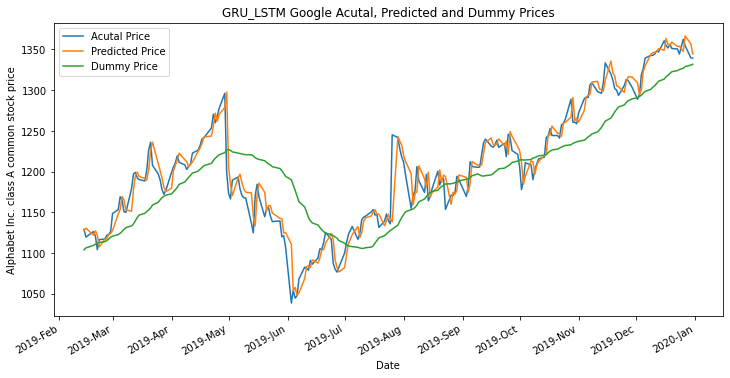

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

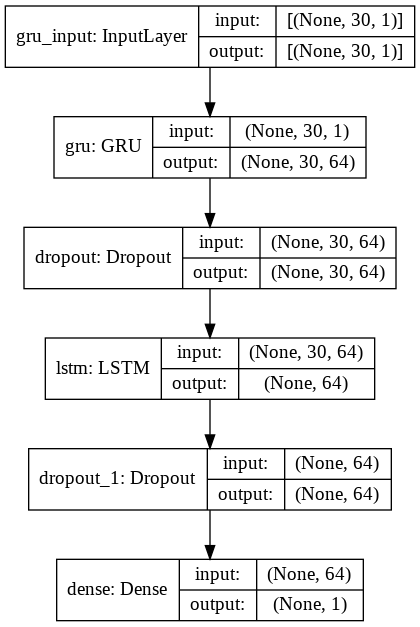

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0033720987107625625
RMSE:  0.05806977450242563
MAE:  0.040434661621181006
Dummy MSE:  0.01786933010743511
Dummy RMSE:  0.13367621369351806
Dummy MAE:  0.10749275974657799


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_LSTM_Google/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_LSTM_Google/assets
